2023-10-28 23:26:42.583285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-28 23:26:42.787176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 23:26:42.787216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 23:26:42.788431: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 23:26:42.886536: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-28 23:26:42.887571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Epoch 1/5
157/157 [==============================] - 1s 3ms/step - loss: 0.6050 - accuracy: 0.8326 - val_loss: 0.3638 - val_accuracy: 0.8980
Epoch 2/5
157/157 [==============================] - 0s 2ms/step - loss: 0.2501 - accuracy: 0.9302 - val_loss: 0.2484 - val_accuracy: 0.9220
Epoch 3/5
157/157 [==============================] - 0s 2ms/step - loss: 0.1748 - accuracy: 0.9530 - val_loss: 0.2075 - val_accuracy: 0.9420
Epoch 4/5
157/157 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.9644 - val_loss: 0.2003 - val_accuracy: 0.9400
Epoch 5/5
157/157 [==============================] - 0s 2ms/step - loss: 0.0913 - accuracy: 0.9780 - val_loss: 0.1943 - val_accuracy: 0.9440


2023-10-28 23:26:54.428263: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3010560000 exceeds 10% of free system memory.
2023-10-28 23:26:56.305196: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3010560000 exceeds 10% of free system memory.


Epoch 1/5
79/79 [==============================] - 965s 12s/step - loss: 0.7739 - accuracy: 0.8450 - val_loss: 0.1519 - val_accuracy: 0.9580
Epoch 2/5
79/79 [==============================] - 571s 7s/step - loss: 0.0873 - accuracy: 0.9752 - val_loss: 0.0790 - val_accuracy: 0.9800
Epoch 3/5
79/79 [==============================] - 563s 7s/step - loss: 0.0416 - accuracy: 0.9920 - val_loss: 0.0574 - val_accuracy: 0.9860
Epoch 4/5
79/79 [==============================] - 567s 7s/step - loss: 0.0272 - accuracy: 0.9946 - val_loss: 0.0672 - val_accuracy: 0.9740
Epoch 5/5
16/16 [==============================] - 51s 3s/step - loss: 0.0519 - accuracy: 0.9740
Test accuracy: 0.9739999771118164


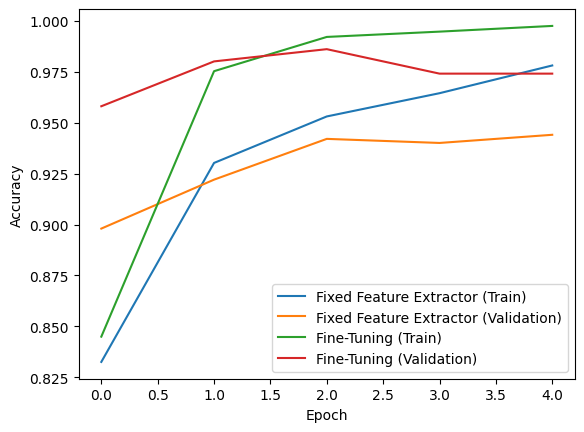

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG19
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Load a subset of the dataset (5000 training images and 500 testing images)
X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_test[:500]
y_test = y_test[:500]

X_train_froz, X_test_froz = X_train / 255.0, X_test / 255.0
y_train_froz, y_test_froz = to_categorical(y_train), to_categorical(y_test)

# Load VGG19 pre-trained model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Fixed feature extractor approach
model_frozen = Sequential()
model_frozen.add(Flatten(input_shape=X_train.shape[1:]))
model_frozen.add(Dense(256, activation='relu'))
model_frozen.add(Dense(10, activation='softmax'))

model_frozen.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the frozen model
history_frozen = model_frozen.fit(X_train_froz, y_train_froz, epochs=5, batch_size=32, validation_data=(X_test_froz, y_test_froz))

# Convert grayscale images to RGB (VGG requires 3 channels)
X_train_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_train, axis=-1))
X_test_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_test, axis=-1))

# Resize images to match VGG input size (224x224)
X_train_resized = tf.image.resize(X_train_rgb, (224, 224))
X_test_resized = tf.image.resize(X_test_rgb, (224, 224))

# Normalize pixel values to [0, 1]
X_train_resized = X_train_resized / 255.0
X_test_resized = X_test_resized / 255.0

# Convert labels to one-hot encoding
y_train_rgb = to_categorical(y_train, num_classes=10)
y_test_rgb = to_categorical(y_test, num_classes=10)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_finetuned = Model(inputs=base_model.input, outputs=output) # Create the fine-tuned model

# Freeze the layers of the base VGG model
for layer in base_model.layers:
    layer.trainable = False

model_finetuned.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_finetuned = model_finetuned.fit(X_train_resized, y_train_rgb, batch_size=64, epochs=5, validation_data=(X_test_resized, y_test_rgb))

# Evaluate the model
loss, accuracy = model_finetuned.evaluate(X_test_resized, y_test_rgb)
print("Test accuracy:", accuracy)

plt.plot(history_frozen.history['accuracy'], label='Fixed Feature Extractor (Train)')
plt.plot(history_frozen.history['val_accuracy'], label='Fixed Feature Extractor (Validation)')
plt.plot(history_finetuned.history['accuracy'], label='Fine-Tuning (Train)')
plt.plot(history_finetuned.history['val_accuracy'], label='Fine-Tuning (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()